<a href="https://colab.research.google.com/github/bshazia/ASP.NET/blob/main/Apple_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance==0.2.12

[link text](https://)**Step 1: Data Collection**

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import datetime
from tensorflow.keras.layers import Input,LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
#daily data for past 10 years
data_daily_copy = yf.download("AAPL", period="10y", interval="1d")
data_daily_copy.to_csv('AAPL_daily_data.csv')

#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")
data_monthly.to_csv('AAPL_monthly_data.csv')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
data_monthly.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-01,38.564999,42.412498,38.115002,42.259998,39.667995,2017165200
2022-12-01,148.210007,150.919998,125.870003,129.929993,128.719360,1675731200
2017-01-01,28.950001,30.610001,28.690001,30.337500,28.126818,2252488000
2014-12-01,29.702499,29.812500,26.565001,27.594999,24.608044,4294378400
2014-09-01,25.764999,25.934999,24.035000,25.187500,22.364164,6105680000


In [4]:
data_daily_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-08-14 to 2024-08-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [5]:
#remove one week
one_week_ago = datetime.date.today() - datetime.timedelta(days=7)

data_daily = data_daily_copy[data_daily_copy.index < pd.Timestamp(one_week_ago)]

data_daily.to_csv('AAPL_data_daily_Week_back.csv')

In [6]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 6.6 KB


In [7]:
# Check for missing dates in daily data
all_dates_daily = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
missing_dates_daily = all_dates_daily.difference(data_daily.index)
print("Missing dates in daily data:", missing_dates_daily)
print("Number of missing dates in daily data:", missing_dates_daily.size)

# Check for missing dates in monthly data
all_dates_monthly = pd.date_range(start=data_monthly.index.min(), end=data_monthly.index.max(), freq='M')
missing_dates_monthly = all_dates_monthly.difference(data_monthly.index)
print("Missing dates in monthly data:", missing_dates_monthly)
print("Number of missing dates in monthly data:", missing_dates_monthly.size)

Missing dates in daily data: DatetimeIndex(['2014-08-16', '2014-08-17', '2014-08-23', '2014-08-24',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-06',
               '2014-09-07', '2014-09-13',
               ...
               '2024-07-06', '2024-07-07', '2024-07-13', '2024-07-14',
               '2024-07-20', '2024-07-21', '2024-07-27', '2024-07-28',
               '2024-08-03', '2024-08-04'],
              dtype='datetime64[ns]', length=1135, freq=None)
Number of missing dates in daily data: 1135
Missing dates in monthly data: DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30',
               ...
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', length=119, freq

In [ ]:
#lets verify it with market calendar
!pip install pandas_market_calendars
import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')

trading_days = nyse.schedule(start_date=data_daily.index.min(), end_date=data_daily.index.max())

non_trading_days = missing_dates_daily[~missing_dates_daily.isin(trading_days.index)]

print("Number of missing dates that are non-trading days:", non_trading_days.size)

these are non-trading days and it's not impacting our data integrity
\

Closing Price
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time

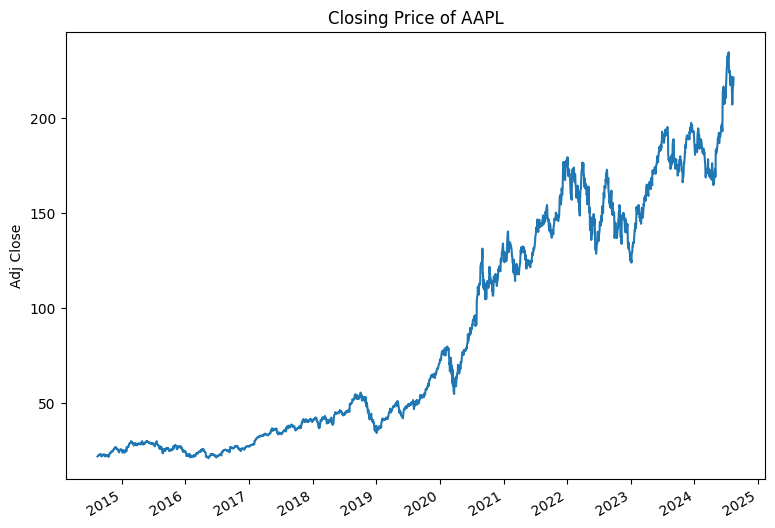

In [19]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

plt.subplot(2, 2, 1)
data_daily_copy['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of AAPL")

plt.tight_layout()

let's check moving average ?

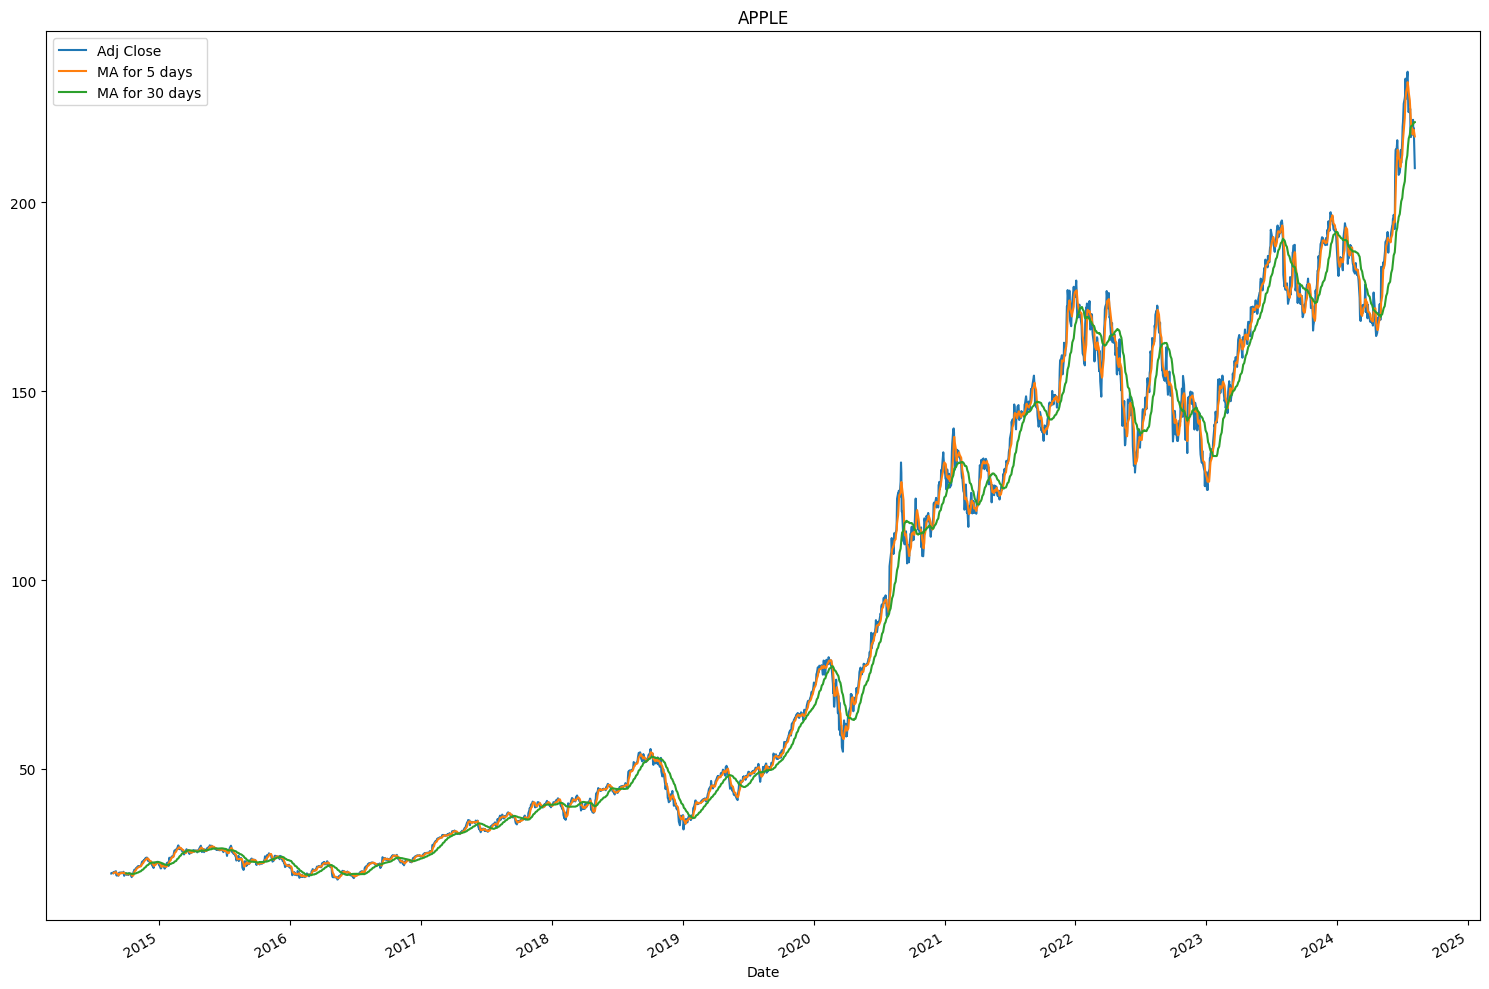

In [28]:
# Calculate moving averages
data_daily['MA for 5 days'] = data_daily['Adj Close'].rolling(window=5).mean()
data_daily['MA for 30 days'] = data_daily['Adj Close'].rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(15, 10))

data_daily[['Adj Close', 'MA for 5 days', 'MA for 30 days']].plot(ax=ax)
ax.set_title('APPLE')

fig.tight_layout()

In [29]:
#let's take only Close column
data = df.filter(['Close'])
# Convert to numpy array
dataset = data.values

#Now let's Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2380

In [30]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01205033],
       [0.01206211],
       [0.01293378],
       ...,
       [0.93997218],
       [0.92244443],
       [0.92951207]])

Training

In [31]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.01205033, 0.01206211, 0.01293378, 0.01319293, 0.01242727,
       0.01388791, 0.01402926, 0.01432375, 0.0152661 , 0.01013029,
       0.00916438, 0.01016562, 0.00944708, 0.00901124, 0.01255684,
       0.01306335, 0.01333428, 0.01329894, 0.01239193, 0.01324005,
       0.01348741, 0.01250972, 0.01262751, 0.01448866, 0.01344029,
       0.00886989, 0.01226235, 0.01150847, 0.01226235, 0.01041299,
       0.01126111, 0.01093129, 0.01093129, 0.00990648, 0.01232126,
       0.01258039, 0.0122388 , 0.01115509, 0.00990648, 0.00848117,
       0.00697341, 0.0086343 , 0.0110962 , 0.01428841, 0.01490094,
       0.01706835, 0.01752775, 0.01739817, 0.01931821, 0.02002497,
       0.01960092, 0.02080242, 0.02245153, 0.02150918, 0.02181544,
       0.02162697, 0.02199214, 0.02178011, 0.02280491, 0.02463072])]
[0.026480083968451168]

[array([0.01205033, 0.01206211, 0.01293378, 0.01319293, 0.01242727,
       0.01388791, 0.01402926, 0.01432375, 0.0152661 , 0.01013029,
       0.00916438, 0.01016562, 0.0

In [34]:
#Let's uild the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2320/2320 ━━━━━━━━━━━━━━━━━━━━ 118s 50ms/step - loss: 0.0033


In [37]:

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


5.1185385806045

**Evaluation**

<ipython-input-56-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


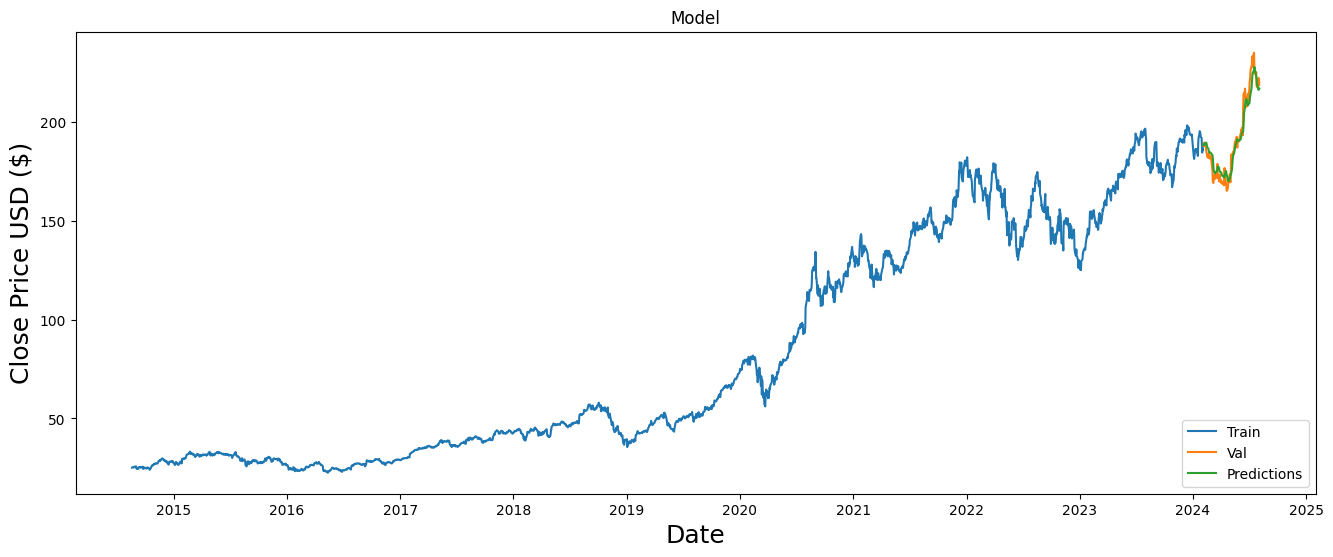

In [56]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [54]:
valid

,Close,Predictions
Date,,
2024-02-05,187.679993,188.456009
2024-02-06,189.300003,187.994156
2024-02-07,189.410004,188.195847
2024-02-08,188.320007,188.685028
2024-02-09,188.850006,189.041855
...,...,...
2024-07-29,218.240005,217.190399
2024-07-30,218.800003,216.364960
2024-07-31,222.080002,216.028366


now let's compare them